# Try out using visJS to make networks more interactive in cells

----------------------

Authors: Brin Rosenthal (sbrosenthal@ucsd.edu), Mikayla Webster (m1webste@ucsd.edu)

----------------------

<a id='toc'></a>
# Table of Contents
1. [Import packages](#import)
2. [Set paths to code](#set_paths)
3. [Create a sample graph for testing](#create_sample_graph)
4. [Draw static graph using NetworkX](#draw_static_graph)
5. [Draw interactive graph using visJS_2_jupyter](#add_visjs)
6. [Time Analysis of visJS_2_jupyter](#time_analysis)
7. [Draw results of heat propagtion simulation interactively](#draw_heat_prop)







# Import packages
<a id='import'></a>


In [68]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random
import json
import os
import math

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

% matplotlib inline

<a id='set_paths'></a>

# Set paths to code


In [69]:
### CHANGE PATHS HERE

import sys
code_path = 'visJS_2_jupyter/'
sys.path.append(code_path)
import visJS_module

sys.path.append('networkProp/')
import network_prop

import imp
imp.reload(visJS_module)

<module 'visJS_module' from 'visJS_2_jupyter/visJS_module.pyc'>

<a id='create_sample_graph'></a>
# Create a graph for testing 

- create a graph using any of the networkx random graph generators
    - all have nodes() and edges() functions, so code is extremely recyclable
    - below are examples of two different networkX graphs: newman_watts_strogatz and planted_partition_graph
- set node attributes
    - clustering coefficient
    - degree
    - betweenness centrality
    
Note: See https://networkx.github.io/ for documentation on networkx functions

**Newman Watts Strogatz:**

In [70]:
# test the interactive visjs network visualization
G = nx.newman_watts_strogatz_graph(10,2,0.5) # make a random graph for testing
                                             # first parameter is number of nodes
                                             # second parameter is node degree/number of edges per node
                                             # third parameter is probability of randomization of node degree
dict_to_string = dict(zip(range(len(G.nodes())),[str(n) for n in G.nodes()]))
G = nx.relabel_nodes(G,dict_to_string)

# create nodes_dict and edges_dict for input to visjs
nodes = G.nodes()
numnodes = len(nodes)
edges = G.edges()
numedges = len(edges)

# add a node attributes to color-code by
cc = nx.clustering(G)
degree = G.degree()
bc = nx.betweenness_centrality(G)
nx.set_node_attributes(G,'clustering_coefficient',cc)
nx.set_node_attributes(G,'degree',degree)
nx.set_node_attributes(G,'betweenness_centrality',bc)

**Planted Partition:**

The planted_partition_graph is a random *community* graph generator

In [71]:
G2 = nx.planted_partition_graph( 3, # number of groups
                             15, # number of vertices of each group
                             0.9, # probability of connected vertices within a group
                             0.1 # probability of connected vertices between groups 
                           )

dict_to_string = dict(zip(range(len(G2.nodes())),[str(n) for n in G2.nodes()]))
G2 = nx.relabel_nodes(G2,dict_to_string)

# create nodes_dict and edges_dict for input to visjs
nodesG2 = G2.nodes()
numnodesG2 = len(nodesG2)
edgesG2 = G2.edges()
numedgesG2 = len(edgesG2)

# add a node attributes to color-code by
ccG2 = nx.clustering(G2)
degreeG2 = G2.degree()
bcG2 = nx.betweenness_centrality(G2)
nx.set_node_attributes(G2,'clustering_coefficient',ccG2)
nx.set_node_attributes(G2,'degree',degreeG2)
nx.set_node_attributes(G2,'betweenness_centrality',bcG2)

<a id='draw_static_graph'></a>

# Old way of drawing graphs in Jupyter cells (not interactive)

**Newman Wattz Strogatzs:**

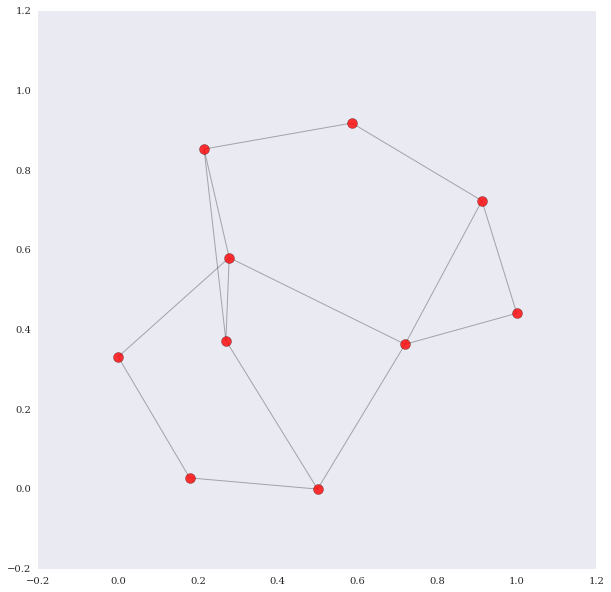

In [72]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos=pos,node_size=100,alpha=.8)
nx.draw_networkx_edges(G,pos=pos,alpha=.3)
plt.grid('off')

**Planted Partition Graph:**

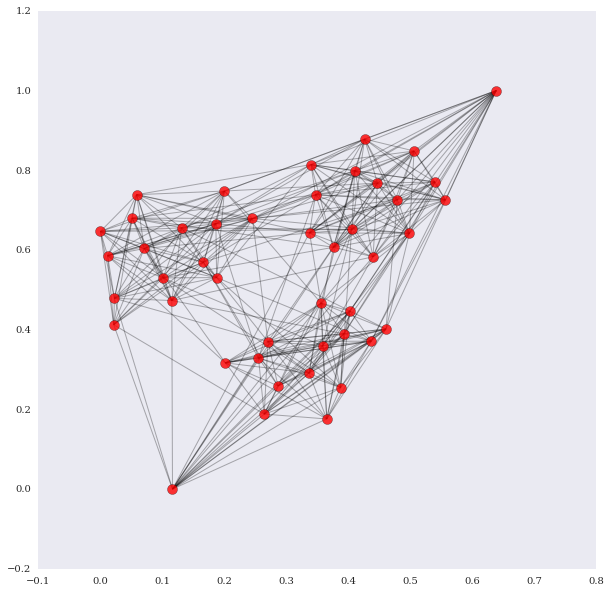

In [73]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2,pos=pos,node_size=100,alpha=.8)
nx.draw_networkx_edges(G2,pos=pos,alpha=.3)
plt.grid('off')

<a id='add_visjs'></a>

# Add visJS functionality to network visualization in Jupyter cells 

- First draw network with some general network properties (clustering coefficient, betweenness centrality, degree)
- Select a field with which to map node colors (can be any node attribute- completely general)
- Can change the colormap (can be any valid python colormap: http://matplotlib.org/examples/color/colormaps_reference.html)

- any other graph drawing properties can be modified by changing arguments (node size, node shape, border colors, hover properties, text properties, etc.). Examples are shown below.


- VisJS documentation found here http://visjs.org/docs/network/


#### Network with default parameters set and betweeness centrality mapped ####
- Required parameters are a nodes dictionary and an edges dictionary
- Though not required, passing in a time_stamp is strongly recommended or it may not be possible to render multiple graphs at once
    - the time_stamp parameter changes the name of the HTML that draws the graph. By default it is set to zero.
- The graph's color scheme represents the betweeness centrality. Darker nodes are passed through more often

**Newman Watts Strogatzs:**

In [74]:
# plotting parameters
field_to_map='betweenness_centrality'

if field_to_map=='clustering_coefficient':
    graph_title = 'Nodes color-coded by clustering coefficient'
    color_map=mpl.cm.cool

elif field_to_map=='betweenness_centrality':
    graph_title = 'Nodes color-coded by betweenness centrality'
    color_map=mpl.cm.spring_r

# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n]} for n in nodes]
        
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": "",
              "hidden":'false', "physics":'true'} for i in range(numedges)]
            

# html file label for first graph (must manually increment later)
time = 0

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time, border_color = "white") 

**Planted Partition Graph:**

In [75]:
# plotting parameters
field_to_map='betweenness_centrality'

if field_to_map=='clustering_coefficient':
    graph_title = 'Nodes color-coded by clustering coefficient'
    color_map=mpl.cm.cool

elif field_to_map=='betweenness_centrality':
    graph_title = 'Nodes color-coded by betweenness centrality'
    color_map=mpl.cm.spring_r

# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G2.nodes(), [3]*len(G2.nodes())))
seed_nodes_YN = dict(zip(G2.nodes(), [0]*len(G2.nodes())))
node_to_color = visJS_module.return_node_to_color(G2,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(G2.nodes(),range(len(G2.nodes()))))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G2.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n]} for n in G2.nodes()]
        
edges_dict = [{"source":node_map[G2.edges()[i][0]], "target":node_map[G2.edges()[i][1]], 
               "color":node_to_color[G2.edges()[i][0]], "id":"", "edge_label": "",
              "hidden":'false', "physics":'true'} for i in range(len(G2.edges()))]
            

# html file label for first graph (must manually increment later)
time = 1

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time, border_color = "white", node_size_multiplier = 3, edge_font_size = 2) 

<b>All of the following example graphs are Newman Watts Strogatz:</b>

#### Network with node and edge labels and shadows manipulated, hide edges on drag enabled, and clustering coefficient mapped ####
- Node and edge labels are the text that are always present (as opposed to title, which only appears on hover)
- Label font color, size, face, background color, stroke width, stroke color, and alignment were manipulated
- Label emboldment on selection was deactivated
- Node Label was changed from id attribute to size attribute (size before scaling)
- Hide edges on drag was enabled
- Edge shadows were added 
- Edge and node shadow color (rather opacity), size, and x and y offset were manipulated
- *Note that parameters were manipulated to extreme values for easy identification*

In [76]:
# plotting parameters
field_to_map=='clustering_coefficient'

if field_to_map=='clustering_coefficient':
    graph_title = 'Nodes color-coded by clustering coefficient'
    color_map=mpl.cm.cool

elif field_to_map=='betweenness_centrality':
    graph_title = 'Nodes color-coded by betweenness centrality'
    color_map=mpl.cm.spring_r

# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n]} for n in nodes]
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": i,
              "hidden":'false', "physics":'true'} for i in range(numedges)]

# mannually increment time stamp in order for next graph to render
time = 2
path_to_visJS_html = 'html/visJS_html_file_temp' + str(time) + '.html'   

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time,
                          
                        # by node
                        node_font_color = 'blue', # color of label text
                        node_font_size = 40, # size of label text
                        node_font_face = 'sans-serif', # font face of label text
                        node_font_background = 'undefined', # when defined with color string, a background rectangle will be drawn around text
                        node_font_stroke_width = 0, # width of stroke, if zero not drawn
                        node_font_stroke_color = '#ffffff', # color of stroke
                        node_font_align = 'left', # other option is 'left'
                        node_label_highlight_bold = False, # determines if label boldens when node is selected
                        node_shadow_enabled = True, # whether there is a shadow cast by the nodes
                        node_shadow_color ='rgba(1,0,0,1)', # shadow color
                        node_shadow_size = 10, # shadow blur size
                        node_shadow_x = 5, # shadow x offset from node
                        node_shadow_y = 5, # shadow y offet from node
                        node_label_field = 'node_size', # field that nodes will be labeled with
                           
                        # by edge
                        hide_edges_on_drag = True, # will edge disappear when dragged?
                        edge_font_color = 'white', # color of label text
                        edge_font_size = 80, # size of label text
                        edge_font_face = 'ariel', # font of label text
                        edge_font_background = 'black', # when given a color string, a background rectangle of that color will be drawn behind the label
                        edge_font_strokeWidth = 0, # stroke drawn around text 
                        edge_font_stroke_color = '#green', # color of stoke
                        edge_font_align = 'bottom', # 'horizontal', 'middle', 'top', or 'bottom'
                        edge_label_highlight_bold = False, # determines whether label becomes bold when edge is selected
                        edge_shadow_enabled = True, # whether or not shadow is cast
                        edge_shadow_color = 'rgba(0,0,0,1)', # color of shadow as a string
                        edge_shadow_size = 40, # blur size of shadow
                        edge_shadow_x = 10, # x offset
                        edge_shadow_y = 10 # y offset
                        ) 

#### Network with manipulated node and edge appearance, fixed node placement, edge arrows, and node augmentation function  ####
- Node and edge border color, highlight background and border color, and hover background and border color were manipulated
- Node border and edge width were manipulated both when selected and not selected
- Nodes movement is fixed in the y direction
- Nodes borders are dashed
- Nodes are box shaped, and box roundness was manipulated
- Edges have arrows coming from source node, in middle of edge, and entering target node
- Edges are dashed
- *Note that parameters were manipulated to extreme values for easy identification*

In [77]:
# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n],
              "node_shape": 'box'} for n in nodes]

edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": i,
              "hidden":'false', "physics":'true'} for i in range(numedges)]

# mannually increment time stamp in order for next graph to render
time = 3
path_to_visJS_html = 'html/visJS_html_file_temp' + str(time) + '.html'

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time,
                           
                                # by node
                                node_border_width = 2, # node border width when not hover or selected
                                node_border_width_selected = 5, # node border width once clicked
                                node_color_border = 'red', # creates border around node shape
                                node_color_highlight_border = 'yellow', # node border color when selected
                                node_color_highlight_background = 'green', # border color when selected
                                node_color_hover_border = 'blue', # color of node border when mouse hovers but does not click
                                node_color_hover_background = 'pink', # color of node when mouse hovers but does not click
                                node_size_field = 'id', # field that determines which nodes are more important thus should be scaled bigger
                                node_size_transform = 'Math.sqrt', # function by which higher value (not node_value) nodes are scaled larger to show importance
                                node_size_multiplier = 10, # increment by which higher value (not node_value) nodes are scaled larger to show importance
                                node_fixed_x = False, # node does not move in x direction but is still calculated into physics
                                node_fixed_y = True, # node does not move in y direction but is still calculated into physics
                                node_shape_border_dashes = True, # makes dashed border around node
                                node_shape_border_radius = 6, # determines roundness of node shape (only for "box" shape)
                           
                                # by edge
                                edge_arrow_to = True, # creates a directed edge with arrow head on receiving node
                                edge_arrow_from = True, # creates a directed edge with arrow head coming from delivering node
                                edge_arrow_middle = True, # creates a directed edge where arrow is in center of edge
                                edge_arrow_to_scale_factor = 1, # changes size of to arrow head
                                edge_arrow_from_scale_factor = 2, # changes size of from arrow head
                                edge_arrow_middle_scale_factor = 3, # changes size of middle arrow head
                                edge_arrow_strikethrough = False, # when False, edge stops at arrow
                                edge_color = 'black', # if all edges are to be a single color, specify here. Empty string refers edge color to each individual object
                                edge_color_highlight = 'pink', # same but for highlight color
                                edge_color_hover = 'purple', # same but for hover color
                                edge_color_inherit = 'to', # if edge color is set, must be false. Else inherits color from "to", "from", or "both" connected nodes 
                                edge_color_opacity = 0.0, # number from 0 - 1 that sets opacity of all edge colorsedge_dashes = False # if true, edges will be drawn with a dashed line
                                edge_dashes = True, # if true, edges will be drawn with a dashed line
                                edge_selection_width = 10, # width of the edge when selected
                                edge_width = 2 # width of all edges (when line gets too think can't see dashes, becomes solid)
                            ) 

#### Network with manipulated edge and node scaling, edge hover width, curve calculation, and length ####
- Node labels and edge labels scale at different rates
- Hover width of edges increased to 10
- edge lengths fixed to 700 (requires orders of magnitude to notice different edge lengths)
- edge function changed to cubic Bezier curve
- *Note that parameters were manipulated to extreme values for easy identification*
- *Note that as of now I haven't figured out icons and images as node shapes, though the code is there*

In [78]:
# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n],
              "node_shape": 'dot'} for n in nodes]

edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": i,
              "hidden":'false', "physics":'true'} for i in range(numedges)]

# mannually increment time stamp in order for next graph to render
time = 4
path_to_visJS_html = 'html/visJS_html_file_temp' + str(time) + '.html'

# create grpah here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time,
                           
                            # by node
                            node_broken_image = 'undefined', # back-up image in case a node image doesn't successfully load
                            node_icon_face = 'FontAwesome', # only used when shape is set to icon. Options are 'FontAwesome' and 'Ionicons'
                            node_icon_code = 'undefined', # code used to define which icon to use
                            node_icon_size = 50, # size of icon
                            node_icon_color = '#2B7CE9', # color of icon
                            node_image = 'undefined', # when shape set to 'image' or 'circularImage', then the URL image designated here will be used
                            node_scaling_min = 10, # min size node can become when it scales down
                            node_scaling_max = 30, # max size node can become when it scales up
                            node_scaling_label_enabled = False, # toggle scaling of label on or off
                            node_scaling_label_min = 14, # min font size the label can become when it scales down
                            node_scaling_label_max = 20, # max font size the label can becomme when it scales up
                            node_scaling_label_max_visible = 20, # font will never be larger than this number at 100% zoom
                            node_scaling_label_draw_threshold = 5, # lower limit font is drawn as, use this and max visible to control which labels remain visible during zoom out
                            node_shape_interpolation = True, # only for image and circular image: image resamples when scaling down
                            node_shape_use_image_size = False, # only for image and circular image: true means use image size, false use our defined node size
                            node_shape_use_border_with_image = False, # only for image: draws border around image icon
                           
                            # by edge
                            edge_hoverWidth = 10, # number to be added to width of edge to determine hovering
                            edge_length = 700, # when a number is defined the edges' spring length is overridden. Takes orders of magnitude to notice difference
                            edge_scaling_min = 1, # minimum allowed edge width value 
                            edge_scaling_max = 1, # maximum allowed edge width value
                            edge_scaling_label_enabled = False, # when true, the label will scale with the edge width
                            edge_scaling_label_min = 2, # min font size used for labels when scaling
                            edge_scaling_label_max = 50, # max font size used for labels when scaling
                            edge_scaling_label_max_visible = 30, # max font size of label will zoom in
                            edge_scaling_label_draw_threshold = 5, # min font size of label when zooming out
                            edge_selfReferenceSize = 20, # when there is a self-loop, this is the radius of that circle
                            edge_smooth_enabled = True, # toggle smoothed curves
                            edge_smooth_type = 'cubicBezier', # determines how edges are drawn. See full documentation for list of options
                            edge_smooth_force_direction = 'vertical', # 'horizontal', 'vertical', and 'none'. Only for cubicBezier curves
                            edge_smooth_roundness = 0.7 # number between 0 and 1 that changes roundness of curve except with dynamic curves
                          ) 

#### Network with miscellaneous edits  ####
- Graph border set to red
- Graph title set to "Hello World!"
- Physics disabled

In [79]:
# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n],
              "node_shape": 'ellipse'} for n in nodes]

edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": i,
              "hidden":'false', "physics":'true'} for i in range(numedges)]

# mannually increment time stamp in order for next graph to render
time = 5
path_to_visJS_html = 'html/visJS_html_file_temp' + str(time) + '.html'

visJS_module.visjs_network(nodes_dict, edges_dict, 

                           border_color = 'red',
                           hover = True,
                           hover_connected_edges = False,
                           physics_enabled = False,
                           min_velocity = 0,
                           max_velocity = 100,
                           drag_nodes = True,
                           draw_threshold = 30,
                           min_label_size = 4,
                           max_label_size = 10,
                           max_visible = 10,
                           graph_title = 'Hello World!',
                           time_stamp = time
                           
                          )

#### Network with changed interaction parameters ####
- Disabled click-and-drag moving of view
- Hid edges and Nodes on drag
- Disabled hover on nodes and their edges
- Increased view moving speed
- Added navigation buttons
- Enabled multiselect
- Changed title pop-up speed to instantaneous

In [22]:
# plotting parameters
field_to_map='betweenness_centrality'

if field_to_map=='clustering_coefficient':
    graph_title = 'Nodes color-coded by clustering coefficient'
    color_map=mpl.cm.cool

elif field_to_map=='betweenness_centrality':
    graph_title = 'Nodes color-coded by betweenness centrality'
    color_map=mpl.cm.spring_r

# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(numnodes)))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n]} for n in nodes]
        
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": "",
              "hidden":'false', "physics":'true'} for i in range(numedges)]
            

# html file label for first graph (must manually increment later)
time = 6

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time,
                            drag_nodes = True,
                            drag_view = False,
                            hide_edges_on_drag = True, 
                            hide_nodes_on_drag = True,
                            hover = False, 
                            hover_connected_edges = False, 
                            keyboard_enabled = True,
                            keyboard_speed_x = 100, 
                            keyboard_speed_y = 100,
                            keyboard_speed_zoom = 0.2,
                            keyboard_bind_to_window = False,
                            multiselect = True,
                            navigation_buttons = True,
                            selectable = True,
                            select_connected_edges = False,
                            tooltip_delay = 0, 
                            zoom_view = False )

#### Network with changed configuartion parameters ####
- Added a GUI at the bottom that allows user to change node and edge parameters

In [80]:
# plotting parameters
field_to_map='betweenness_centrality'

if field_to_map=='clustering_coefficient':
    graph_title = 'Nodes color-coded by clustering coefficient'
    color_map=mpl.cm.cool

elif field_to_map=='betweenness_centrality':
    graph_title = 'Nodes color-coded by betweenness centrality'
    color_map=mpl.cm.spring_r

# per node and per edge attributes
color_vals_transform = None
node_to_nodeSize = dict(zip(G.nodes(), [3]*len(G.nodes())))
seed_nodes_YN = dict(zip(G.nodes(), [0]*len(G.nodes())))
node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map,
                                                  color_vals_transform=color_vals_transform)
node_map = dict(zip(nodes,range(len(G.nodes()))))  # map to indices for source/target in edges

# dictionaries that hold per node and per edge attributes
nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_to_nodeSize[n],'border_width':seed_nodes_YN[n]} for n in G.nodes()]
        
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]], "id":i, "edge_label": "",
              "hidden":'false', "physics":'true'} for i in range(len(G.edges()))]
            

# html file label for first graph (must manually increment later)
time = 7

# create graph here
visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time,
                            config_enabled = True, # Toggle the configuration interface on or off. This is an optional parameter. If left undefined and any of the other properties of this object are defined, this will be set to true.
                            config_filter = "nodes, edges", # When a string is supplied, any combination of the following is allowed: nodes, edges, layout, interaction, manipulation, physics, selection, renderer. Feel free to come up with a fun seperating character. Finally, when supplied an array of strings, any of the previously mentioned fields are accepted. 
                            container = "undefined", # This allows you to put the configure list in another HTML container than below the network.
                            showButton = True, # Show the generate options button at the bottom of the configurator.
                           )

<a id='time_analysis'></a>

# Time Analysis and Visualization Limitations of visJS_network function

## Newman Watts Strogatz:##

### Comparison of Graphs of Different Edge Densities ###

- Information on symbols:
    - |V| is the number of nodes
    - |E| is the number of edges
    - ~|E|/v is the approximate number of edges per node
    - NWS is Newman Watts Strogatzs, which is the type of random graph generator used
    - prob is the probability of adding a new edge to a node
    - <a href = "http://networkx.readthedocs.io/en/networkx-1.11/reference/generated/networkx.generators.random_graphs.newman_watts_strogatz_graph.html#networkx.generators.random_graphs.newman_watts_strogatz_graph"> See here for NWS documentation
- Information on timing process:
    - timing was done using the "timeit" python function
    - the times recorded are how long it takes the visJS_network funtion to run. They are not representative of how long it takes to render the image (which is much longer)
    - All time tests were run with default parameter settings
- Results, Analysis, and Limits:
    - Variation of prob did little to effect time
    - |E|/v must be strictly less than |V| or the NWS throws an error
    - No lower limit on number of nodes or edges (as long as numedges is still less than numnodes). Negative numbers and zero produce a blank graph.
    - The amount of time it takes to render the image is proportional to both the time it takes to run the function and the number of objects (nodes and edges) that are in the graph. 
    - At about 32 ms or about 8000 objects (whichever comes first) the rendering process becomes so slow that even if the image manages to load (will take on the order of 10 minutes), the entire program becomes so laggy that it is sometimes not possible to even scroll up and down. (I had to restart the program several times in this case)
    - The visual runs more slowly at a faster rate when number of edges is increased, as opposed to when number of nodes increases

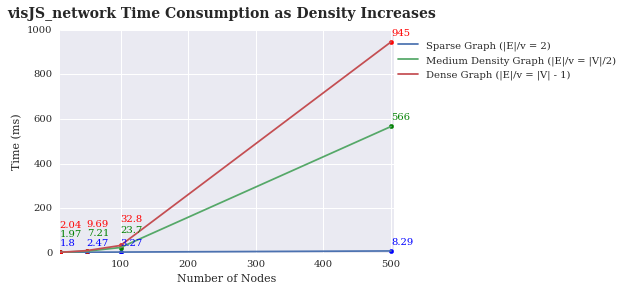

In [81]:
numnodes = [10, 50 , 100, 500]
sparse_time = [1.8, 2.47, 3.27, 8.29]
medium_time = [1.97, 7.21, 23.7, 566]
dense_time = [2.04, 9.69, 32.8, 945]

density_comparison_graph = plt.figure()
density_comparison_graph.suptitle("visJS_network Time Consumption as Density Increases", fontsize = 14, fontweight = "bold")
axes_dcg = density_comparison_graph.add_subplot(111)
plt.xlim(10, 505)
plt.ylim(0, 1000)
axes_dcg.set_xlabel("Number of Nodes")
axes_dcg.set_ylabel("Time (ms)")

sparse_line = axes_dcg.plot(numnodes, sparse_time, label = "Sparse Graph (|E|/v = 2)")
sparse_scat = axes_dcg.scatter(numnodes, sparse_time, color = "blue")

medium_line = axes_dcg.plot(numnodes, medium_time, label = "Medium Density Graph (|E|/v = |V|/2)")
medium_scat = axes_dcg.scatter(numnodes, medium_time, color = "green")

dense_line = axes_dcg.plot(numnodes, dense_time, label = "Dense Graph (|E|/v = |V| - 1)")
dense_scat = axes_dcg.scatter(numnodes, dense_time, color = "red")

for i in range(len(numnodes) - 1):
    axes_dcg.annotate(dense_time[i], xy = (numnodes[i], dense_time[i]), xytext = (numnodes[i], dense_time[i] + 110), color = "red")
    axes_dcg.annotate(medium_time[i], xy = (numnodes[i], medium_time[i]), xytext = (numnodes[i], medium_time[i] + 70), color = "green")
    axes_dcg.annotate(sparse_time[i], xy = (numnodes[i], sparse_time[i]), xytext = (numnodes[i], sparse_time[i] + 30), color = "blue")

i = len(numnodes) - 1
axes_dcg.annotate(dense_time[i], xy = (numnodes[i], dense_time[i]), xytext = (numnodes[i], dense_time[i] + 30), color = "red")
axes_dcg.annotate(medium_time[i], xy = (numnodes[i], medium_time[i]), xytext = (numnodes[i], medium_time[i] + 30), color = "green")
axes_dcg.annotate(sparse_time[i], xy = (numnodes[i], sparse_time[i]), xytext = (numnodes[i], sparse_time[i] + 30), color = "blue")

handles, labels = axes_dcg.get_legend_handles_labels()
density_comparison_graph.legend(handles, labels, loc = "upper left", bbox_to_anchor = (0.9,0.9))

### Spare Graph Analysis ###
- At 200 nodes and above, the visualization causes the notebook to lag.
- At 600 nodes and less, the visualization takes 3 minutes or less to load.
- At 1500 nodes with about 5 edges per node, the number of objects is approximately 7500. The visualization took over 10 minutes to load, though did successfully load. Afterwards, the notebook was nearly unresponsive. 

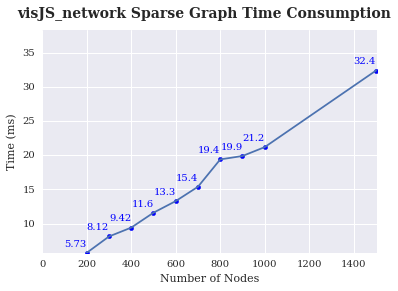

In [82]:
numnodes2 = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500]
sparse_time2 = [5.73, 8.12, 9.42, 11.6, 13.3, 15.4, 19.4, 19.9, 21.2, 32.4]

sparse_graph = plt.figure()
sparse_graph.suptitle("visJS_network Sparse Graph Time Consumption", fontsize = 14, fontweight = "bold")
axes_s = sparse_graph.add_subplot(111)
plt.xlim(0, 1505)
plt.ylim(5.73, 38.4)
axes_s.set_xlabel("Number of Nodes")
axes_s.set_ylabel("Time (ms)")

sparse_line2 = axes_s.plot(numnodes2, sparse_time2, label = "Sparse Graph (|E|/v = 5)")
sparse_scat2 = axes_s.scatter(numnodes2, sparse_time2, color = "blue")

for i in range(len(numnodes2)):
    axes_s.annotate(sparse_time2[i], xy = (numnodes2[i], sparse_time2[i]), xytext = (numnodes2[i] - 100, sparse_time2[i] + 1), color = "blue")

### Dense Graph Analysis ###
- At 80 nodes (79 edges, about 6400 objects) the graph loaded after several minutes and the program was moderately lagging.
- At 90 nodes (89 edges, about 8100 objects) the program crashed.
- At 50 nodes (49 edges, about 2500 objects) the program starts to lag.

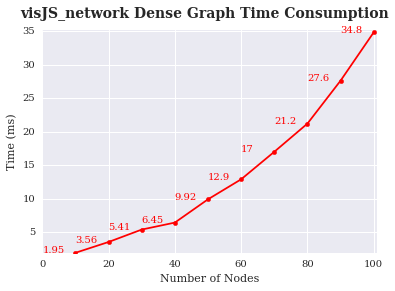

In [83]:
numnodes3 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dense_time2 = [1.95, 3.56, 5.41, 6.45, 9.92, 12.9, 17, 21.2, 27.6, 34.8]

dense_graph = plt.figure()
dense_graph.suptitle("visJS_network Dense Graph Time Consumption", fontsize = 14, fontweight = "bold")
axes_d = dense_graph.add_subplot(111)

plt.xlim(0, 101)
plt.ylim(1.95, 35.2)
axes_d.set_xlabel("Number of Nodes")
axes_d.set_ylabel("Time (ms)")

dense_line2 = axes_d.plot(numnodes3, dense_time2, label = "Dense Graph (|E|/v = |V| - 1)", color = "red")
dense_scat2 = axes_d.scatter(numnodes3, dense_time2, color = "red")

for i in range(len(numnodes3)):
    axes_d.annotate(dense_time2[i], xy = (numnodes3[i], dense_time2[i]), xytext = (numnodes3[i] - 10, dense_time2[i]), color = "red")

## Planted Partition Graph: ##

### Time Analysis as Number of Nodes Increases ###
- This analysis was performed with a prob_in and prob_ex of 0.1
- The planted partition graph takes two node-related parameters: number of groups and number of nodes per group
- time consumption is dependent upon the total number of nodes, not necessarily number of groups or number of nodes per group specifically
- planted partition graph is more susceptible to node number increasing than the Newman Watts Strogatz
    - It is hard to get a low number of edges as the number of nodes increases because the number of edges cannot be directly controlled
    - At 300 nodes/29.9 ms, the visual takes several minutes to load, and the progrm becomes nearly unresponsive
    - At 400 nodes/54.7 ms (or rather somewhere between 300 and 400 nodes), the program crashes

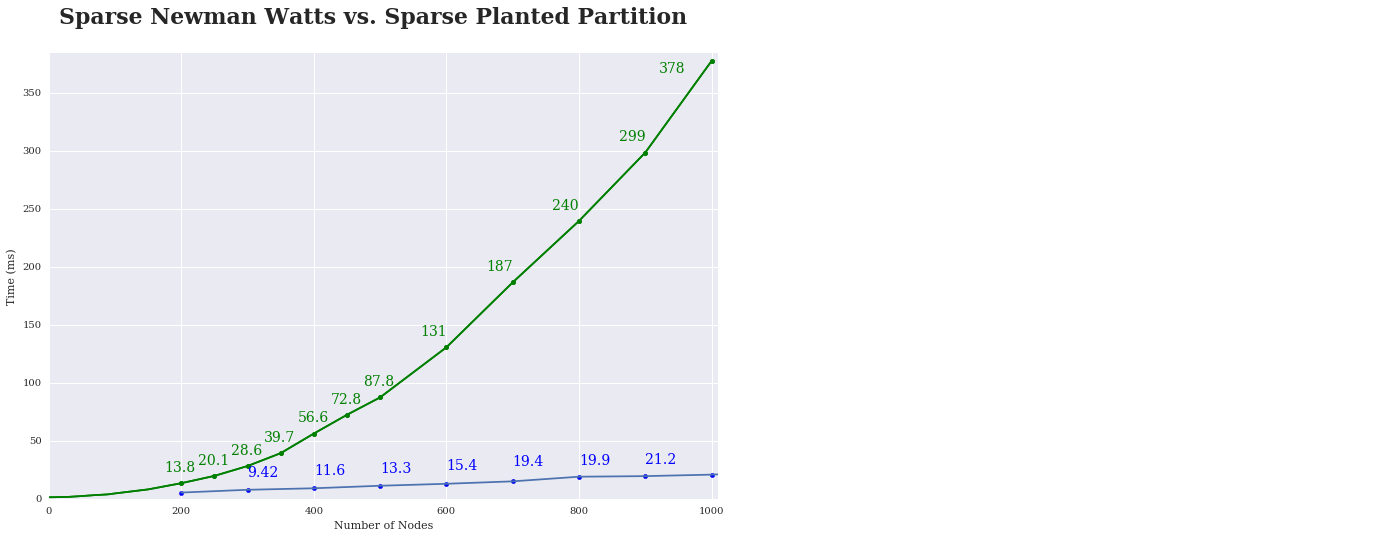

In [84]:
numnodes4 = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]
plant_part_time = [1.69, 1.71, 1.75, 1.91, 2.01, 2.36, 2.72, 3.13, 3.55, 3.84, 4.2, 4.98, 8.45, 13.8, 20.1, 28.6, 39.7, 56.6, 72.8, 87.8, 131, 187, 240, 299, 378]

PP_graph = plt.figure(figsize=(12,8))
PP_graph.suptitle("Sparse Newman Watts vs. Sparse Planted Partition", fontsize = 22, fontweight = "bold")
axes_pp = PP_graph.add_subplot(111)

plt.xlim(0, 1010)
plt.ylim(0, 385)
axes_pp.set_xlabel("Number of Nodes")
axes_pp.set_ylabel("Time (ms)")

PP_line = axes_pp.plot(numnodes4, plant_part_time, color = "green")
PP_scat = axes_pp.scatter(numnodes4[13:], plant_part_time[13:], color = "green")

PPN_line = axes_pp.plot(numnodes4, plant_part_time, color = "green")
PPN_scat = axes_pp.scatter(numnodes4[13:], plant_part_time[13:], color = "green")

sparse_line2 = axes_pp.plot(numnodes2, sparse_time2, label = "Sparse Graph (|E|/v = 5)")
sparse_scat2 = axes_pp.scatter(numnodes2, sparse_time2, color = "blue")

for i in range(2, len(numnodes2)):
    axes_pp.annotate(sparse_time2[i], xy = (numnodes2[i], sparse_time2[i]), xytext = (numnodes2[i] - 100, sparse_time2[i] + 10), color = "blue", size = 14)

for i in range(20, len(numnodes4) - 1):
    axes_pp.annotate(plant_part_time[i], xy = (numnodes4[i], plant_part_time[i]), xytext = (numnodes4[i] - 40, plant_part_time[i] + 10), color = "green", size = 14)
    
for i in range(13, 20):
    axes_pp.annotate(plant_part_time[i], xy = (numnodes4[i], plant_part_time[i]), xytext = (numnodes4[i] - 25, plant_part_time[i]+10), color = "green", size = 14)
    
i = len(numnodes4) - 1
axes_pp.annotate(plant_part_time[i], xy = (numnodes4[i], plant_part_time[i]), xytext = (numnodes4[i] - 80, plant_part_time[i] - 10), color = "green", size = 14)

### TIme Consumption as Intraconnectivity increases ###
- The number of nodes was kept at 100 
- Prob_ex wasa kept at 0.1
- There are generally fewer nodes within a group that outside of that group, so increasing the probability of adding a connection does not add a tremendous number of edges

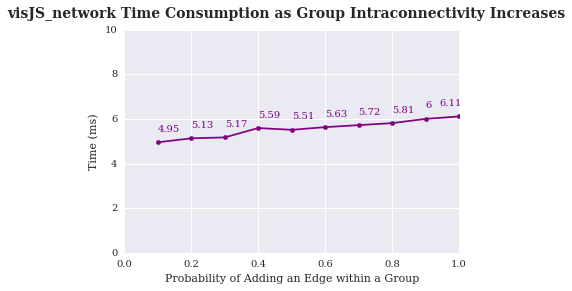

In [85]:
prob_in = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
PP_time2 = [4.95, 5.13, 5.17, 5.59, 5.51, 5.63, 5.72, 5.81, 6, 6.11]

PPG = plt.figure()
PPG.suptitle("visJS_network Time Consumption as Group Intraconnectivity Increases", fontsize = 14, fontweight = "bold")
axes_PP2 = PPG.add_subplot(111)

plt.xlim(0, 1)
plt.ylim(0, 10)
axes_PP2.set_xlabel("Probability of Adding an Edge within a Group")
axes_PP2.set_ylabel("Time (ms)")

axes_PP2.plot(prob_in, PP_time2, color = "purple")
axes_PP2.scatter(prob_in, PP_time2, color = "purple")

for i in range(len(prob_in) - 1):
    axes_PP2.annotate(PP_time2[i], xy = (prob_in[i], PP_time2[i]), xytext = (prob_in[i], PP_time2[i] + 0.5), color = "purple")
    
i = len(prob_in) - 1
axes_PP2.annotate(PP_time2[i], xy = (prob_in[i], PP_time2[i]), xytext = (prob_in[i] - 0.06, PP_time2[i] + 0.5), color = "purple")

### Time Consumption as Interconnectivity Increases ###
- The number of nodes was kept at 100 
- Prob_in wasa kept at 0.1
- There are much more nodes outside a given group than within one, so increasing prob_ex drastically effects time consuption 

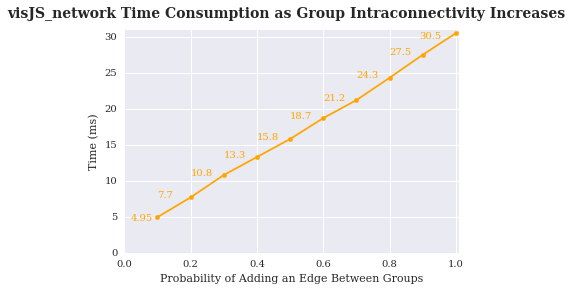

In [86]:
prob_ex = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
PP_time3 = [4.95, 7.7, 10.8, 13.3, 15.8, 18.7, 21.2, 24.3, 27.5, 30.5]

PPG3 = plt.figure()
PPG3.suptitle("visJS_network Time Consumption as Group Intraconnectivity Increases", fontsize = 14, fontweight = "bold")
axes_PP3 = PPG3.add_subplot(111)

plt.xlim(0, 1.01)
plt.ylim(0, 31)
axes_PP3.set_xlabel("Probability of Adding an Edge Between Groups")
axes_PP3.set_ylabel("Time (ms)")

axes_PP3.plot(prob_ex, PP_time3, color = "orange")
axes_PP3.scatter(prob_ex, PP_time3, color = "orange")

for i in range(1, len(prob_ex) - 1):
    axes_PP3.annotate(PP_time3[i], xy = (prob_ex[i], PP_time3[i]), xytext = (prob_ex[i] - 0.1, PP_time3[i]), color = "orange")
    
i = len(prob_ex) - 1
axes_PP3.annotate(PP_time3[i], xy = (prob_ex[i], PP_time3[i]), xytext = (prob_ex[i] - 0.11, PP_time3[i] - 0.7), color = "orange")
axes_PP3.annotate(PP_time3[0], xy = (prob_ex[0], PP_time3[0]), xytext = (prob_ex[0] - 0.08, PP_time3[0] - 0.5), color = "orange")

<a id='draw_heat_prop'></a>

# Next draw the network using heat propagation to color-code nodes

- Heat propagation was implemented following methods in: Vanunu, Oron, et al. "Associating genes and protein complexes with disease via network propagation." PLoS Comput Biol 6.1 (2010): e1000641.

In [87]:
def heat_prop_visJS(G, seed_nodes, alpha = 0.5, num_its = 20, time_stamp = 0):
    
    # add seed_nodes to node attributes
    seed_nodes_YN = pd.Series(0,index=G.nodes())
    seed_nodes_YN[seed_nodes]=1
    seed_nodes_YN = dict(seed_nodes_YN)

    nx.set_node_attributes(G,'is_seed',seed_nodes_YN)

    Wprime = network_prop.normalized_adj_matrix(G)
    Fnew = network_prop.network_propagation(G,Wprime,seed_nodes)

    Fnew = dict(Fnew)
    nx.set_node_attributes(G,'heat',Fnew)

    # set heat prop parameters
    field_to_map = 'heat'
    color_map = mpl.cm.jet
    color_vals_transform = 'log'
    
    # creating border widths
    border_widths = dict(zip(G.nodes(), [0] * len(G.nodes())))
    for i in range(len(seed_nodes)):
        border_widths[seed_nodes[i]] = 3
        
    # creating node sizes
    node_sizes = dict(zip(G.nodes(), [10] * len(G.nodes())))
    min_value = 0
    for i in range(len(G.nodes())):
        node_sizes[Fnew.keys()[i]] = math.log(Fnew.values()[i])
        if math.log(Fnew.values()[i]) < min_value:
            min_value = math.log(Fnew.values()[i])
    
    for i in range(len(G.nodes())):
        node_sizes[Fnew.keys()[i]] = pow((node_sizes[Fnew.keys()[i]] + abs(min_value) + 1.5), 1.2)

    #nodes = Fnew.keys()
    #node_size = [int(n/np.max(nodes)*25+1) for n in nodes]
    node_to_nodeSize = dict(zip(Fnew.keys(), [100]*len(G.nodes())))
    node_to_color = visJS_module.return_node_to_color(G,field_to_map=field_to_map,cmap=color_map, color_vals_transform=color_vals_transform)
    node_map = dict(zip(nodes,range(len(G.nodes()))))  # map to indices for source/target in edges
    
    nodes_dict = [{"id":n,"degree":G.degree(n),"color":node_to_color[n],
              "node_size":node_sizes[n],'border_width':border_widths[n],
              "node_shape": 'dot'} for n in nodes]

    edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
               "color":node_to_color[edges[i][0]]} for i in range(numedges)]            

    # create graph here
    return visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp = time_stamp, node_size_field = "node_size", 
                                      node_color_border = "black", node_color_highlight_background = 'pink', 
                                      node_color_highlight_border = "purple", node_border_width_selected  = 6)
    #return node_sizes
# run the heat propagation from some seed nodes
heat_prop_visJS(G = G, seed_nodes = G.nodes()[0:3], alpha = 0.5, num_its = 20, time_stamp = 8)